In [23]:
import csv
import matplotlib.pyplot as plt


def load_bank_data(filename):
	banks = []
	with open(filename, 'r') as file:
		reader = csv.DictReader(file, delimiter=';')
		for row in reader:
			bank = {
				'name': row['name'],
				'Interest Rate (%)': float(row['Interest Rate (%)']),
				'Max Loan Amount($)': float(row['Max Loan Amount($)']),
				'Origination Fee (%)': float(row['Origination Fee (%)']),
				'Late Payment Fee ($)': float(row['Late Payment Fee ($)']),
				'Max Loan Tenure (years)': float(row['Max Loan Tenure (years)']),
				'Prepayment Penalty (%)': float(row['Prepayment Penalty (%)'])
			}
			banks.append(bank)
	return banks


banks = load_bank_data('banks.csv')

In [24]:
criteria_props = {
	'Interest Rate (%)': 'min',
	'Max Loan Amount($)': 'max',
	'Origination Fee (%)': 'min',
	'Late Payment Fee ($)': 'min',
	'Max Loan Tenure (years)': 'max','Prepayment Penalty (%)': 'min'
}

def normalize_data(banks, criteria_properties):
	min_vals = {}
	max_vals = {}
	
	for criterion in criteria_properties:
		values = [bank[criterion] for bank in banks]
		min_vals[criterion] = min(values)
		max_vals[criterion] = max(values)
	
	normalized_banks = []
	for bank in banks:
		normalized_bank = {'name': bank['name']}
		for criterion, direction in criteria_properties.items():
			if direction == 'min':
				if max_vals[criterion] == min_vals[criterion]:
					normalized_bank[criterion] = 1.0
				else:
					normalized_bank[criterion] = (max_vals[criterion] - bank[criterion]) / (
						max_vals[criterion] - min_vals[criterion])
			else:  # maximize
				if max_vals[criterion] == min_vals[criterion]:
					normalized_bank[criterion] = 1.0
				else:
					normalized_bank[criterion] = (bank[criterion] - min_vals[criterion]) / (
						max_vals[criterion] - min_vals[criterion])
		normalized_banks.append(normalized_bank)
	
	return normalized_banks


norm_banks = normalize_data(banks, criteria_props)

### lexicographic order method

In [25]:

criteria_order = ['Interest Rate (%)', 'Max Loan Amount($)', 'Origination Fee (%)',
'Max Loan Tenure (years)', 'Prepayment Penalty (%)', 'Late Payment Fee ($)'
]


def lexicographic_order(banks, criteria_order, criteria_properties):
	sorted_banks = banks.copy()
	for i in range(len(criteria_order) - 1, -1, -1):
		criterion = criteria_order[i]
		reverse = (criteria_properties[criterion] == 'maximize')
		
		for j in range(1, len(sorted_banks)):
			key = sorted_banks[j]
			k = j - 1
			while k >= 0 and (
				(not reverse and sorted_banks[k][criterion] > key[criterion]) or
				(reverse and sorted_banks[k][criterion] < key[criterion])
			):
				sorted_banks[k + 1] = sorted_banks[k]
				k -= 1
			sorted_banks[k + 1] = key
	
	return sorted_banks


lex_res = lexicographic_order(norm_banks, criteria_order, criteria_props)
# 
# print("ranked by lex order:")
# for i, bank in enumerate(lex_res, 1):
# 	print(f"{i}. {bank['name']}")
# 	for criterion in criteria_order:
# 		print(f"{criterion}: {bank[criterion]:.3f}")

In [26]:

def find_pareto_optimal(banks, criteria_properties):
	pareto_optimal = []
	for i, bank in enumerate(banks):
		is_dominated = False
		for j, other_bank in enumerate(banks):
			if i == j:
				continue
			
			dominates = True
			for criterion, direction in criteria_properties.items():
				if direction == 'minimize':
					if other_bank[criterion] > bank[criterion]:
						dominates = False
						break
				else:  # maximize
					if other_bank[criterion] < bank[criterion]:
						dominates = False
						break
			
			if dominates:
				is_dominated = True
				break
		
		if not is_dominated:
			pareto_optimal.append(bank)
	
	return pareto_optimal


pareto_optimal_b = find_pareto_optimal(norm_banks, criteria_props)
# 
# print("\npareto-opt banks:")
# for b in pareto_optimal_b:
# 	print(f"{b['name']}")

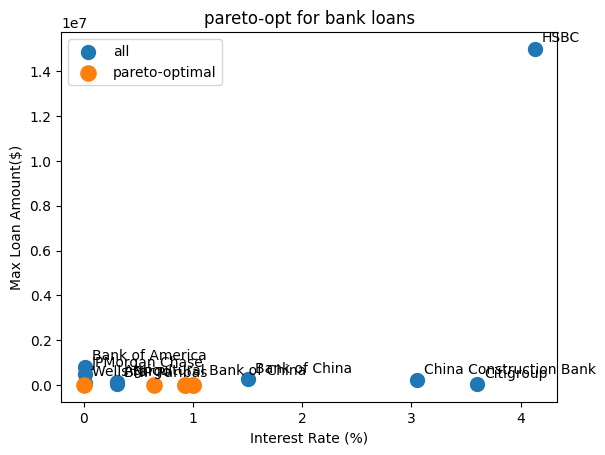

In [27]:

criterion_x,  criterion_y = criteria_order[:2]

plt.figure()
x_vals = [bank[criterion_x] for bank in banks]
y_vals = [bank[criterion_y] for bank in banks]
plt.scatter(x_vals, y_vals, s=100, label='all')
for bank in banks:
	plt.annotate(
		bank['name'],
		(bank[criterion_x], bank[criterion_y]),
		xytext=(5, 5),
		textcoords='offset points',
	)

pareto_x = [bank[criterion_x] for bank in pareto_optimal_b]
pareto_y = [bank[criterion_y] for bank in pareto_optimal_b]
plt.scatter(pareto_x, pareto_y,
	s=120, label='pareto-optimal'
)

plt.xlabel(criterion_x)
plt.ylabel(criterion_y)
plt.title('pareto-opt for bank loans')
plt.legend()
plt.show()